# Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scipy.stats import beta

# Step 1: Get the prior data from before

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [5]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [6]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [7]:
def transform_values(i,n,prior=1/2):
    return (i*(n-1)+prior)/n

In [8]:
prior_a, prior_b, loc, scale = beta.fit([transform_values(i, len(train_videos.values),1/2)
                                          for i in train_videos.values], floc=0, fscale=1)

In [9]:
prior_a *= 10
prior_b *= 10
print(prior_a, prior_b)

14.270965891341989 5.916156493565227


# Step 2: Load in the kuairec test dataset in case we need it

In [14]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [16]:
num_samples = 100

In [17]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [18]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [19]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[0, num_samples//4, 2*num_samples//4, 3*num_samples//4, -2, -1]].keys())
videos_of_interest

[9136, 9885, 6172, 7257, 2687, 7076]

In [20]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

# Step 3: Load in simulation data

In [54]:
data_dict = dict()
for val in [0.0, 0.3, 0.7, 1.0]:
    data_dict[val] = np.load(f'soal_sims/sim_data_alpha_{val}.npy',allow_pickle=True)[()]

In [66]:
data_dict[0.0].keys()

dict_keys([10328, 1351, 6757, 1095, 4028, 8915, 4706, 4443, 7039, 6763, 1299, 7227, 8475, 6259, 8359, 6293, 4158, 4685, 9736, 3191, 4659, 2365, 10257, 701, 2475, 10462, 5596, 5448, 7226, 4556, 2559, 2578, 7695, 7293, 3064, 3970, 9177, 2029, 2503, 9149, 632, 6788, 937, 4571, 8681, 4041, 5731, 5690, 8736, 3125, 4451, 1170, 423, 2045, 5326, 4131, 9882, 3118, 5612, 9682, 4076, 1439, 589, 1212, 4188, 1386, 7014, 2573, 579, 5535, 3866, 5838, 845, 2575, 9995, 9925, 9102, 5876, 5813, 983, 5537, 8162, 1452, 8629, 10078, 10589, 7109, 7526, 9898, 5865, 2521, 542, 9947, 1126, 4145, 9571, 4554, 6251, 4632, 3082])

# Step 4: Plotting time

## Step 4.1 - how impactful is early performance on later plays?

In [169]:
# build the modified data dict from the existing data dict

quantile_df = pd.qcut(video_df,q=5,labels=[1,2,3,4,5])
modified_data_dict = dict()
for k in data_dict:
    d = dict()
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            if traj.shape[0] >= 101:
                prod_id = l if k==0.0 else l[0]
                traj_qual = quantile_df[prod_id] # get quality to closest multiple of 0.2
                truncated_traj = copy.deepcopy(traj)[10:101,:]
                num_likes_at_10 = int(np.sum(truncated_traj[0,0]) - np.sum(traj[0,0]))
                num_likes_at_10 = 3 if num_likes_at_10 > 3 else num_likes_at_10
                truncated_traj = np.sum(truncated_traj, axis=1) - np.sum(traj[0,:])
                if (num_likes_at_10, traj_qual) in d:
                    d[(num_likes_at_10, traj_qual)].append(truncated_traj)
                else:
                    d[(num_likes_at_10,traj_qual)] = [truncated_traj]
                
    modified_data_dict[k] = d

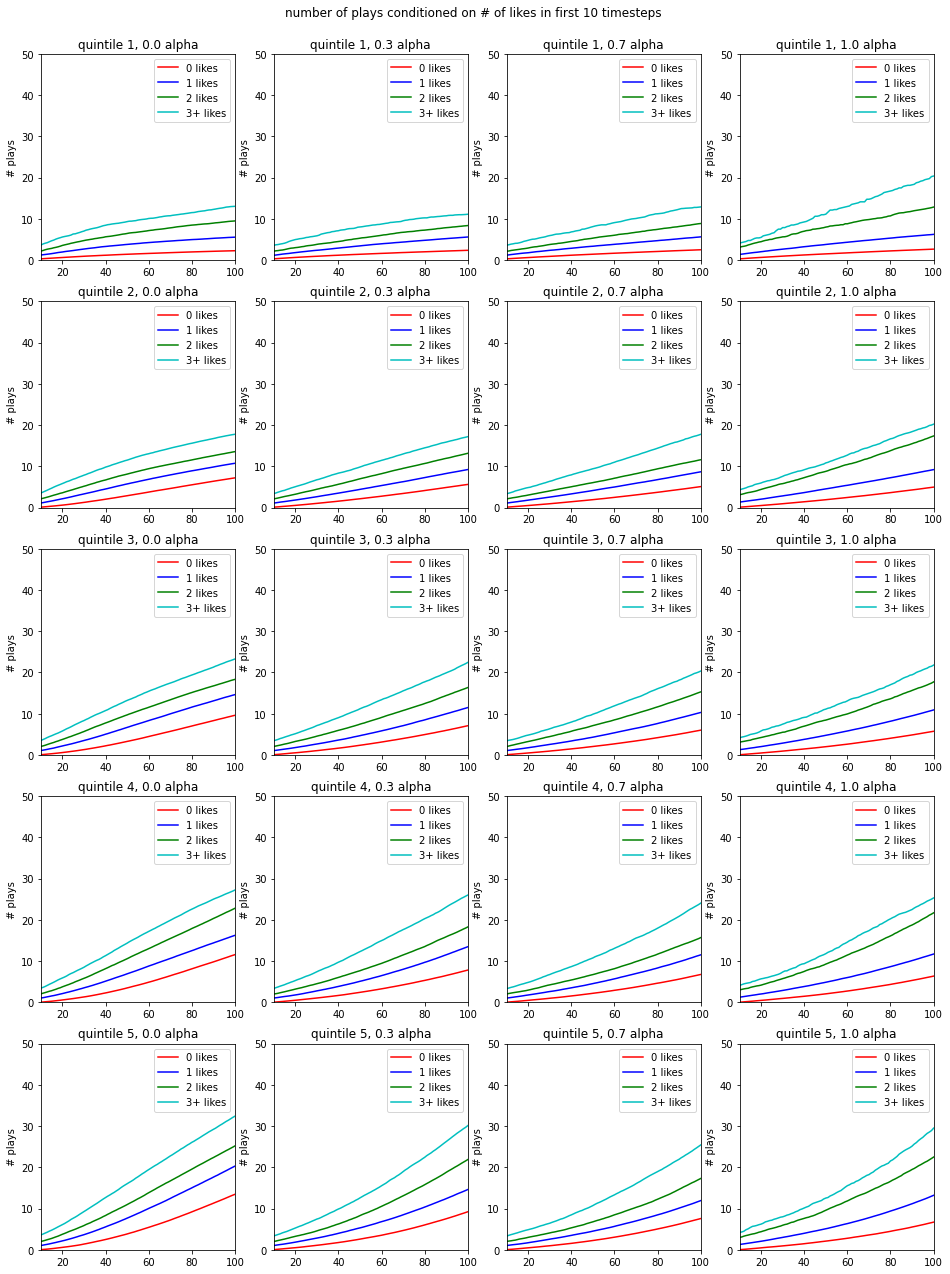

In [185]:
f, axes = plt.subplots(5,4)
f.set_size_inches(16,22)
qualities = [1,2,3,4,5]
colours = ['r','b','g','c','m','y']
f.suptitle('number of plays conditioned on # of likes in first 10 timesteps',y=0.91)
for i in range(len(modified_data_dict.keys())):
    k = list(modified_data_dict.keys())[i]
    for j in range(len(qualities)):
        relevant_keys = [m for m in modified_data_dict[k].keys() if qualities[j]==m[1]]
        relevant_keys = sorted(relevant_keys)
        plt.sca(axes[j,i])
        xlims = np.linspace(10,100,91)
        plt.xlim((10,100))
        plt.ylim((0,50))
        plt.ylabel('# plays')
        plt.title(f'quintile {qualities[j]}, {k} alpha')
        for t in range(len(relevant_keys)):
            m = relevant_keys[t]
            data = np.mean(copy.deepcopy(modified_data_dict[k][m]),axis=0)
            lab = f'{m[0]} likes' if m[0] < 3 else f'{m[0]}+ likes'
            plt.plot(xlims, data, label=lab, color=colours[t])
            plt.legend()
            
plt.show()
        

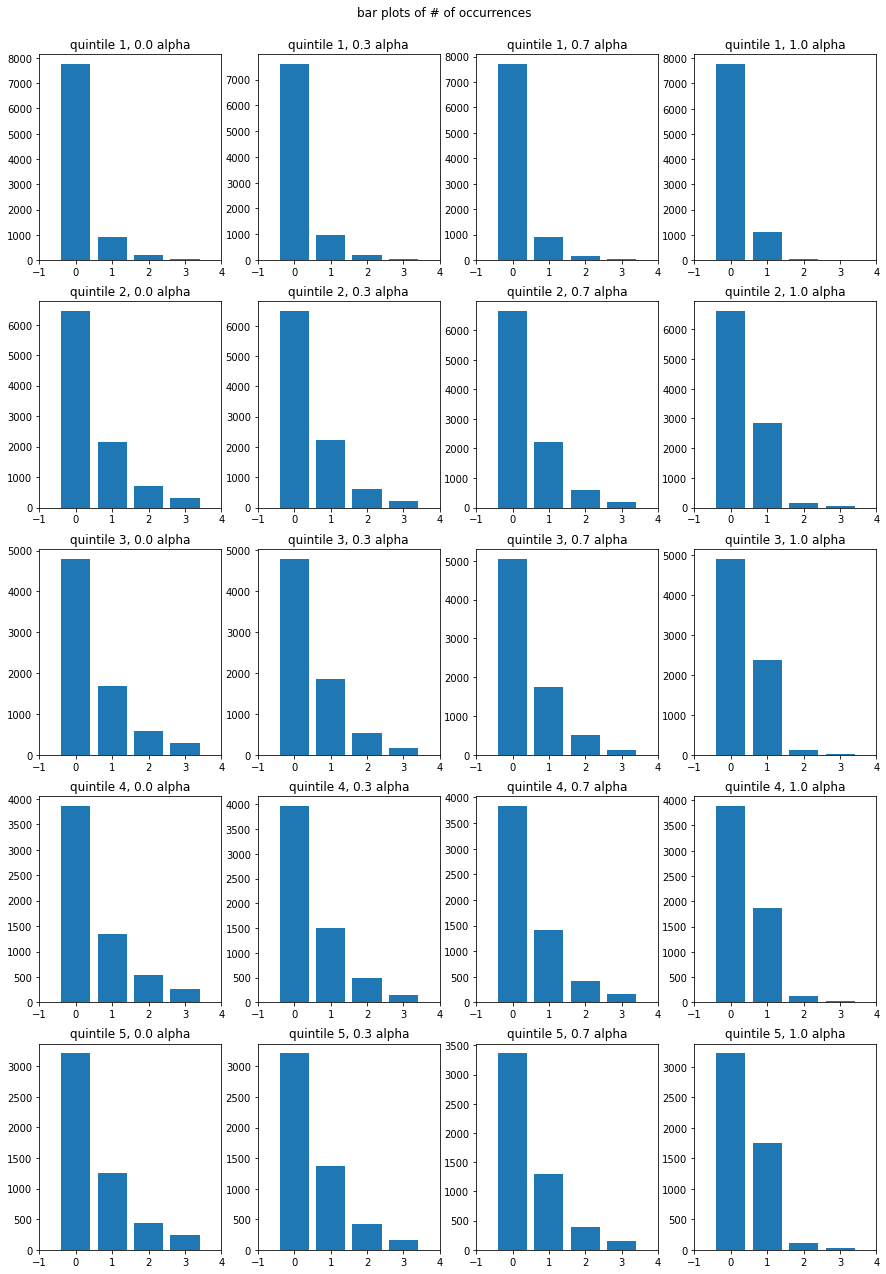

In [184]:
f, axes = plt.subplots(5,4)
f.set_size_inches(15,22)
qualities = [1,2,3,4,5]
colours = ['r','b','g','c','m','y']
f.suptitle('bar plots of # of occurrences',y=0.91)
for i in range(len(modified_data_dict.keys())):
    k = list(modified_data_dict.keys())[i]
    for j in range(len(qualities)):
        relevant_keys = [m for m in modified_data_dict[k].keys() if qualities[j]==m[1]]
        relevant_keys = sorted(relevant_keys)
        plt.sca(axes[j,i])
        plt.xlim((-1,4))
        xlims = np.linspace(10,100,91)
        plt.title(f'quintile {qualities[j]}, {k} alpha')
        data = [len(copy.deepcopy(modified_data_dict[k][relevant_keys[t]])) for t in range(len(relevant_keys))]
        x_vals = range(len(data))
        plt.bar(x=x_vals, height=data)
            
plt.show()

video_id
103      2
109      4
120      4
122      3
128      2
        ..
10506    5
10519    5
10552    1
10589    3
10595    5
Name: liked, Length: 3327, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]